# Timelag Analysis
Build a small module for easily producing timelag maps from stacks of AIA images. Use primarily with simulations, but could be used with observations as well.

In [7]:
import os
from imp import reload

import h5py
import numpy as np
from scipy.interpolate import splev
import dask
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
import sunpy
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.utils.console import ProgressBar

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

from timelags import AIATimeLags

%matplotlib inline

In [ ]:
client = dask.distributed.Client()
client

Make instrument for each case we want to look at

In [2]:
aia_cooling = InstrumentSDOAIA([0,10000]*u.s)
aia_cooling.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/SDO_AIA_counts.h5'
aia_high = InstrumentSDOAIA([10000,20000]*u.s)
aia_high.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis/high_frequency/nei/SDO_AIA_counts.h5'
aia_intermediate = InstrumentSDOAIA([10000,20000]*u.s)
aia_intermediate.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis/intermediate_frequency/nei/SDO_AIA_counts.h5'
aia_low = InstrumentSDOAIA([10000,20000]*u.s)
aia_low.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis/low_frequency/nei/SDO_AIA_counts.h5'

Now load in all the data for our four heating cases. For now, we'll look only at the NEI cases.

In [3]:
tl_cooling = AIATimeLags(aia_cooling, '/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/')

FloatProgress(value=0.0)

In [4]:
tl_high = AIATimeLags(aia_high, '/storage-home/w/wtb2/data/timelag_synthesis/high_frequency/nei/')

FloatProgress(value=0.0)

In [5]:
tl_intermediate = AIATimeLags(aia_intermediate, '/storage-home/w/wtb2/data/timelag_synthesis/intermediate_frequency/nei/')

FloatProgress(value=0.0)

In [6]:
tl_low = AIATimeLags(aia_low, '/storage-home/w/wtb2/data/timelag_synthesis/low_frequency/nei/')

FloatProgress(value=0.0)

## AIA Maps

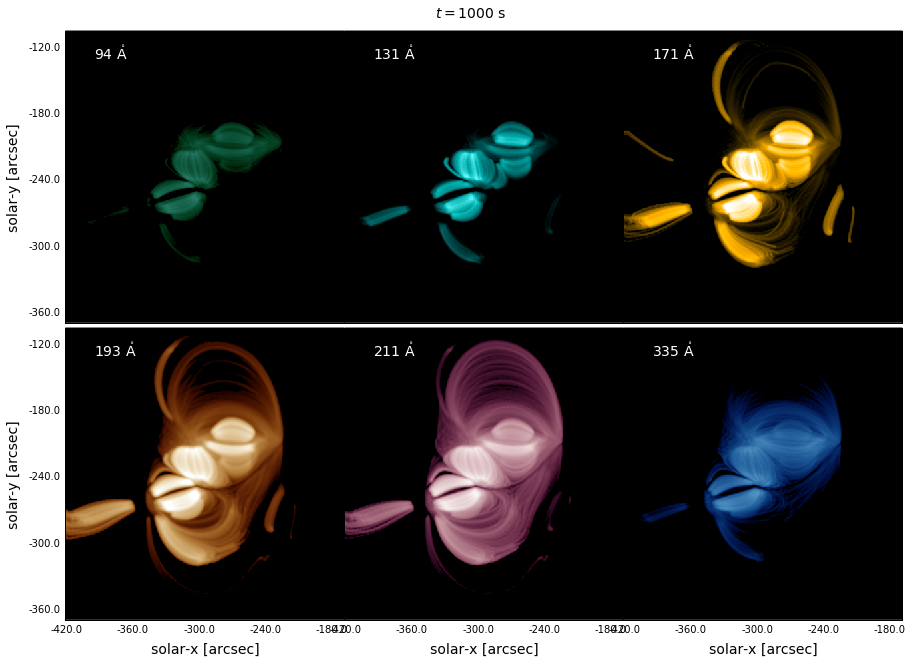

In [8]:
plot_aia_channels(aia_cooling,1000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/')

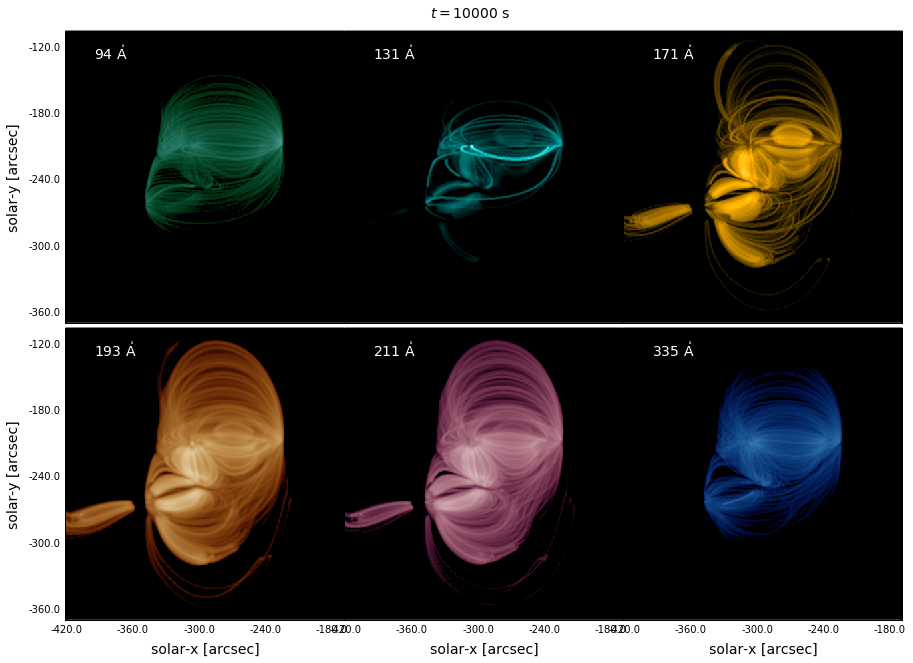

In [9]:
plot_aia_channels(aia_high,10000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis/high_frequency/nei/')

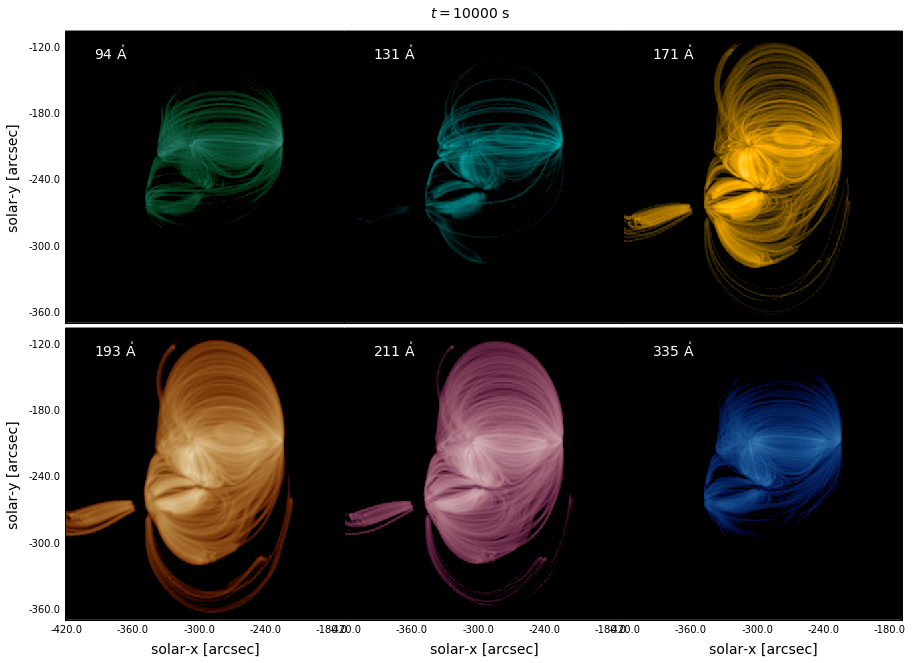

In [10]:
plot_aia_channels(aia_intermediate,10000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis/intermediate_frequency/nei/')

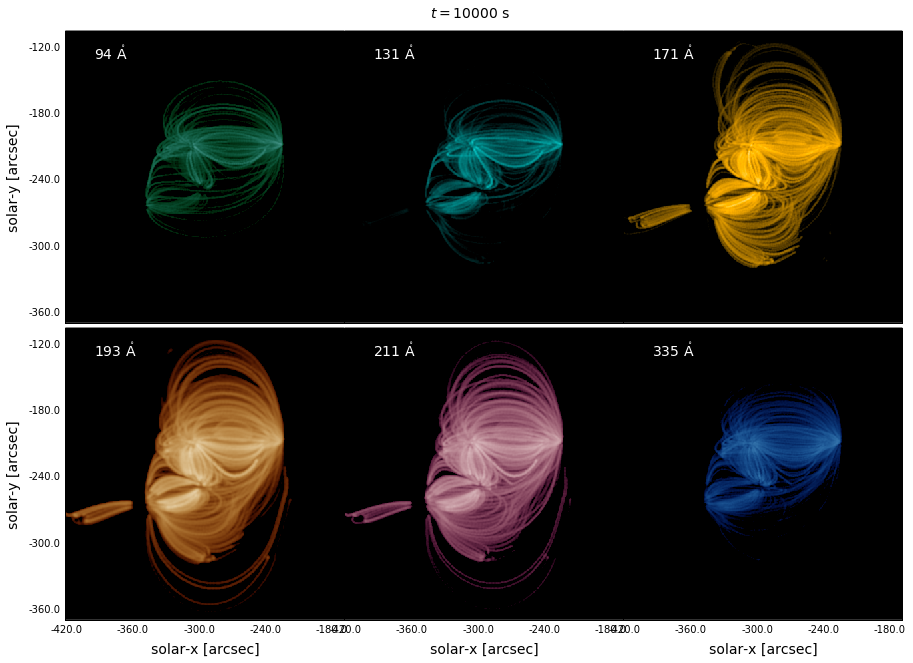

In [11]:
plot_aia_channels(aia_low,10000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis/low_frequency/nei/')

## 1D Correlations
Take a 1D slice averaged over a few pixels for each group and compute the timelags for a few channel pairs

In [13]:
xc,yc = tmp.center.Tx,tmp.center.Ty#-240*u.arcsec,-210*u.arcsec
dx,dy = 1*u.arcsec,1*u.arcsec#tmp.dimensions.y*tmp.scale.axis2
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)

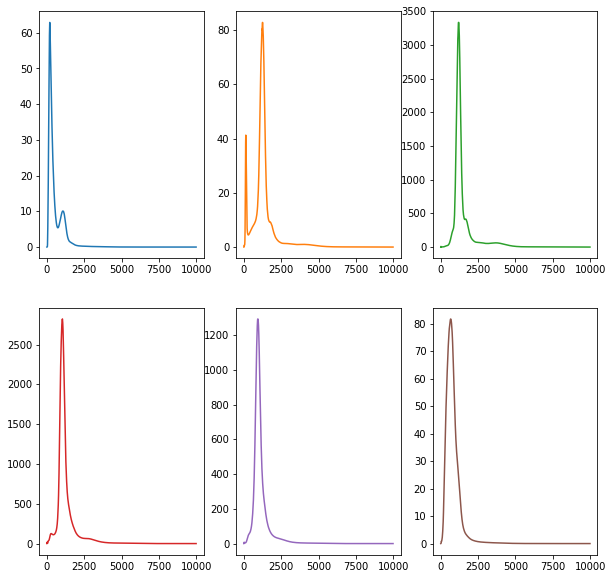

In [14]:
fig,axes = plt.subplots(2,3,figsize=(10,10))
for i,(channel,ax) in enumerate(zip(aia_cooling.channels,axes.flatten())):
    ts_cooling = tl_cooling.make_timeseries(tl_cooling.cubes,channel['name'],lower_left_corner,upper_right_corner)
    ax.plot(aia_cooling.observing_time,ts_cooling,color=f'C{i}')

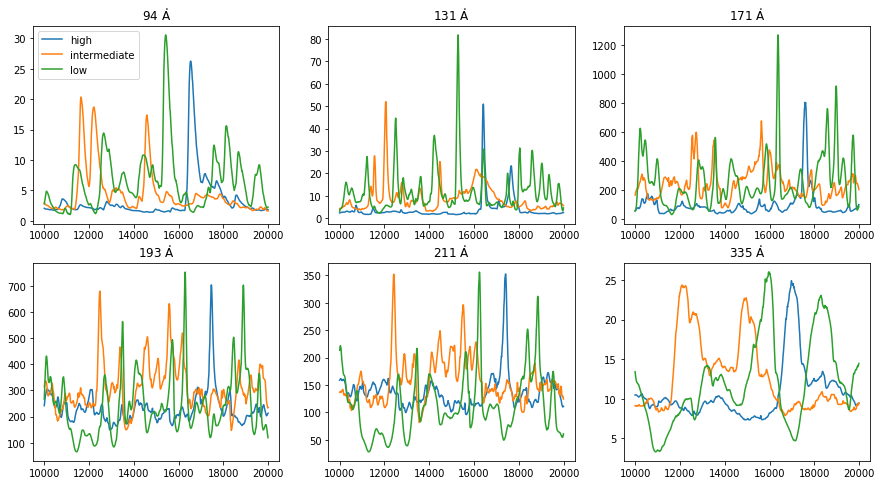

In [15]:
fig,axes = plt.subplots(2,3,figsize=(15,8))
coords  = (lower_left_corner,upper_right_corner)
for i,(channel,ax) in enumerate(zip(aia_cooling.channels,axes.flatten())):
    ts_high = tl_high.make_timeseries(tl_high.cubes,channel['name'],*coords)
    ax.plot(aia_high.observing_time,ts_high,color=f'C0',label='high')
    ts_intermediate = tl_intermediate.make_timeseries(tl_intermediate.cubes,channel['name'],*coords)
    ax.plot(aia_intermediate.observing_time,ts_intermediate,color=f'C1',label='intermediate')
    ts_low = tl_low.make_timeseries(tl_low.cubes,channel['name'],*coords)
    ax.plot(aia_low.observing_time,ts_low,color=f'C2',label='low')
    ax.set_title(f'{channel["name"]} $\mathring{{\mathrm{{A}}}}$')
axes[0,0].legend()

In [16]:
channel_pairs = [(94,335),(94,171),(335,211),(335,171),(193,171),(171,131)]

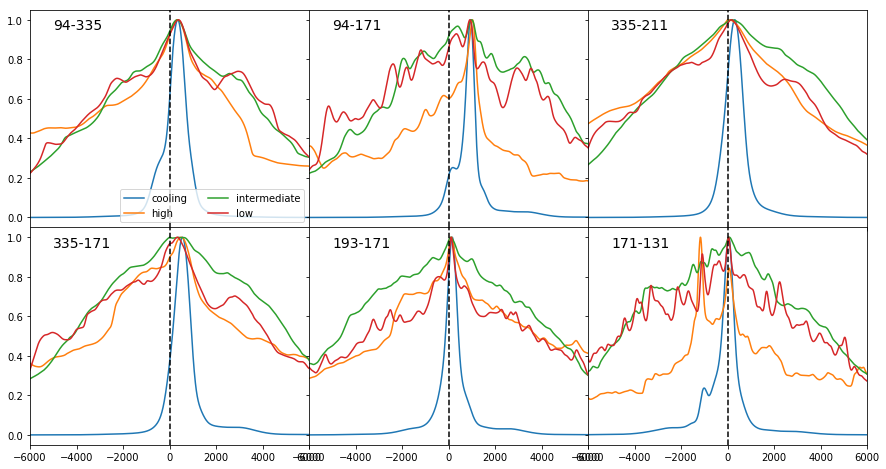

In [17]:
fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    # cooling
    cc_cooling = tl_cooling.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_cooling.timelags,cc_cooling/cc_cooling.max(),color=f'C0',ls='-',label='cooling')
    # high frequency
    cc_high = tl_high.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_high.timelags,cc_high/cc_high.max(),color=f'C1',ls='-',label='high')
    # intermediate frequency
    cc_intermediate = tl_intermediate.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_intermediate.timelags,cc_intermediate/cc_intermediate.max(),color=f'C2',ls='-',label='intermediate')
    # low frequency
    cc_low = tl_low.correlation_1d(f'{p[0]}', f'{p[1]}',*coords)
    ax.plot(tl_low.timelags,cc_low/cc_low.max(),color=f'C3',ls='-',label='low')
    ax.axvline(x=0,ls='--',color='k')
    ax.text(-5e3,0.95,'{}-{}'.format(*p),fontsize=14)
axes[0,0].set_xlim([-6e3,6e3])
axes[0,0].legend(loc=4,ncol=2)
plt.subplots_adjust(hspace=0,wspace=0)

## 2D Timelag Maps
Now, compute the timelag maps for several different channel pairs for all four of our different heating functions. From Viall and Klimchuk (2017), we want to look at the channel pairs,

* 94-335
* 94-171
* 335-211
* 335-171
* 193-171
* 171-131

Compute maps and histograms for each of these. Show grid of timelag maps, rows are the channel pairs, columns are the heating models. Finally, 

In [ ]:
cooling_timelags = {}
for p in channel_pairs:
    cor_map,tl_map = tl_cooling.make_timelag_map(f'{p[0]}',f'{p[1]}')
    cooling_timelags['{}-{}'.format(*p)] = {
        'timelag_map':tl_map,
        'correlation_map':cor_map
    }

In [ ]:
for p in channel_pairs:
    (cooling_timelags['{}-{}'.format(*p)]['correlation_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/timelag_maps/timelag_map_{}_{}.fits'.format(*p)))
    (cooling_timelags['{}-{}'.format(*p)]['timelag_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/timelag_maps/correlation_map_{}_{}.fits'.format(*p)))

In [ ]:
high_timelags = {}
for p in channel_pairs:
    cor_map,tl_map = tl_high.make_timelag_map(f'{p[0]}',f'{p[1]}')
    high_timelags['{}-{}'.format(*p)] = {
        'timelag_map':tl_map,
        'correlation_map':cor_map
    }

In [ ]:
for p in channel_pairs:
    (high_timelags['{}-{}'.format(*p)]['timelag_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/high_frequency/nei/timelag_maps/timelag_map_{}_{}.fits'.format(*p)))
    (high_timelags['{}-{}'.format(*p)]['correlation_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/high_frequency/nei/timelag_maps/correlation_map_{}_{}.fits'.format(*p)))

In [ ]:
intermediate_timelags = {}
for p in channel_pairs:
    cor_map,tl_map = tl_intermediate.make_timelag_map(f'{p[0]}',f'{p[1]}')
    intermediate_timelags['{}-{}'.format(*p)] = {
        'timelag_map':tl_map,
        'correlation_map':cor_map
    }

In [ ]:
for p in channel_pairs:
    (intermediate_timelags['{}-{}'.format(*p)]['timelag_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/intermediate_frequency/nei/timelag_maps/timelag_map_{}_{}.fits'.format(*p)))
    (intermediate_timelags['{}-{}'.format(*p)]['correlation_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/intermediate_frequency/nei/timelag_maps/correlation_map_{}_{}.fits'.format(*p)))

In [ ]:
low_timelags = {}
for p in channel_pairs:
    cor_map,tl_map = tl_low.make_timelag_map(f'{p[0]}',f'{p[1]}')
    low_timelags['{}-{}'.format(*p)] = {
        'timelag_map':tl_map,
        'correlation_map':cor_map
    }

In [ ]:
for p in channel_pairs:
    (low_timelags['{}-{}'.format(*p)]['timelag_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/low_frequency/nei/timelag_maps/timelag_map_{}_{}.fits'.format(*p)))
    (low_timelags['{}-{}'.format(*p)]['correlation_map']
     .save('/storage-home/w/wtb2/data/timelag_synthesis/low_frequency/nei/timelag_maps/correlation_map_{}_{}.fits'.format(*p)))

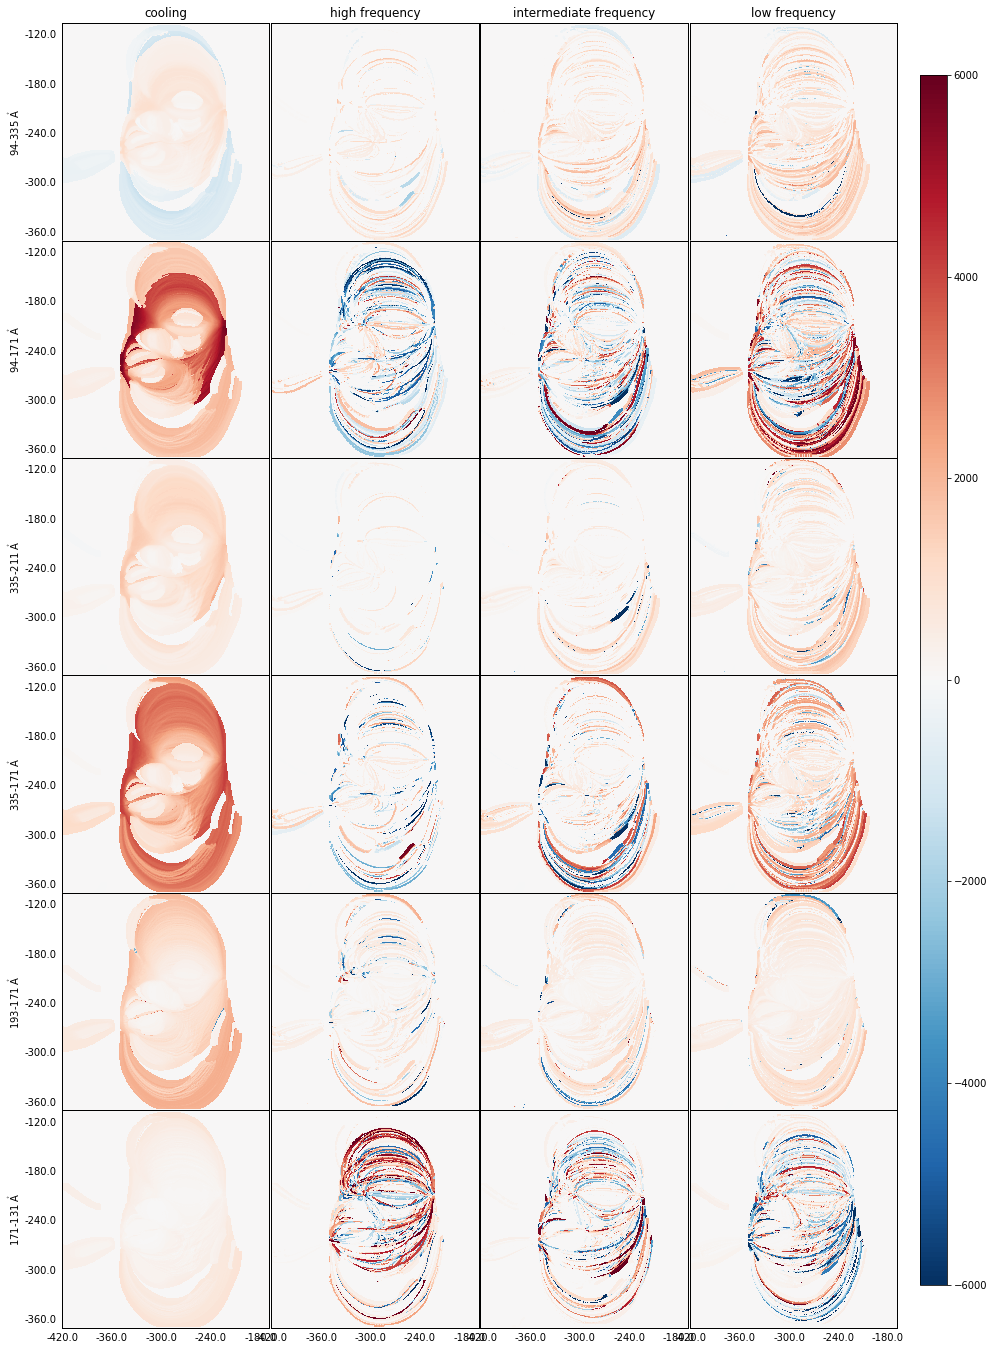

In [20]:
fig = plt.figure(figsize=(15,24))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
# cooling
for i,p in enumerate(channel_pairs):
    for j,heating in enumerate(['cooling','high_frequency','intermediate_frequency','low_frequency']):
        tmp = Map(tlm_format.format(heating,*p))
        tmp.plot_settings.update({'cmap':'RdBu_r','vmin':-6e3,'vmax':6e3})
        ax = fig.add_subplot(len(channel_pairs),4,4*i+j+1,projection=tmp)
        im = tmp.plot(annotate=False,title=False)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0:
            lat.set_axislabel('{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
        if i<len(channel_pairs)-1:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        if i==0:
            ax.set_title(' '.join(heating.split('_')))
cbar = fig.colorbar(im, cax=cax)

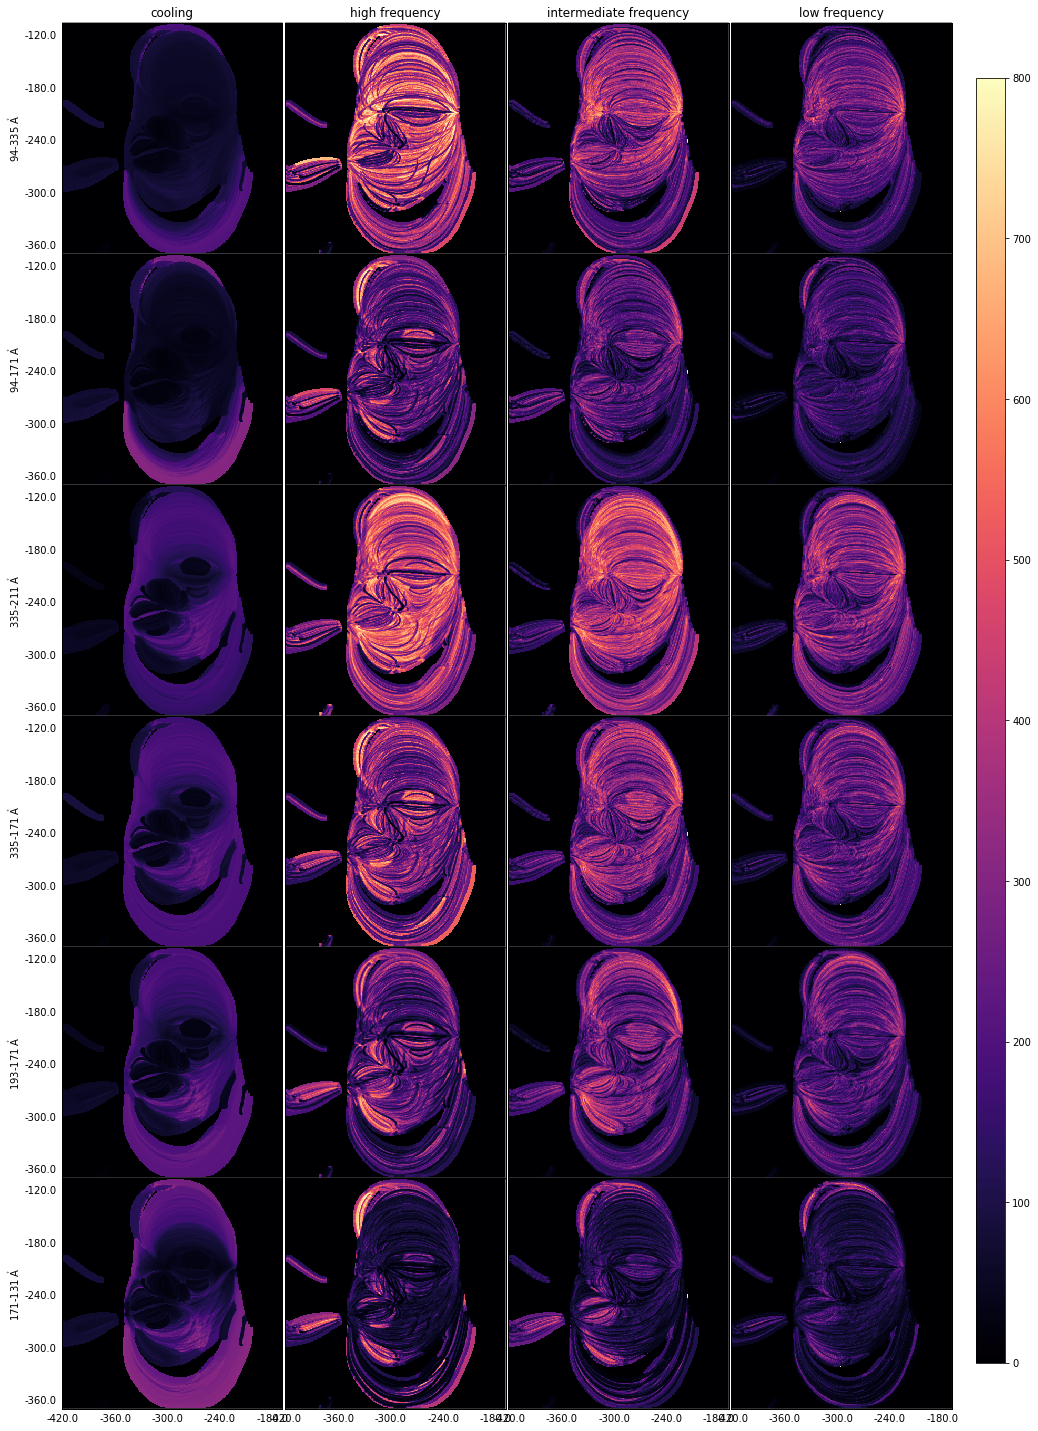

In [23]:
fig = plt.figure(figsize=(16,25.5))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/correlation_map_{}_{}.fits'
# cooling
for i,p in enumerate(channel_pairs):
    for j,heating in enumerate(['cooling','high_frequency','intermediate_frequency','low_frequency']):
        tmp = Map(tlm_format.format(heating,*p))
        tmp.plot_settings.update({'cmap':'magma','vmin':0,'vmax':8e2})
        ax = fig.add_subplot(len(channel_pairs),4,4*i+j+1,projection=tmp)
        im = tmp.plot(annotate=False,title=False)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0:
            lat.set_axislabel('{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
        if i<len(channel_pairs)-1:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        if i==0:
            ax.set_title(' '.join(heating.split('_')))
cbar = fig.colorbar(im, cax=cax)

## Timelag Distributions

Finally, compare them on a histogram

Text(0.5,0,'timelag [s]')

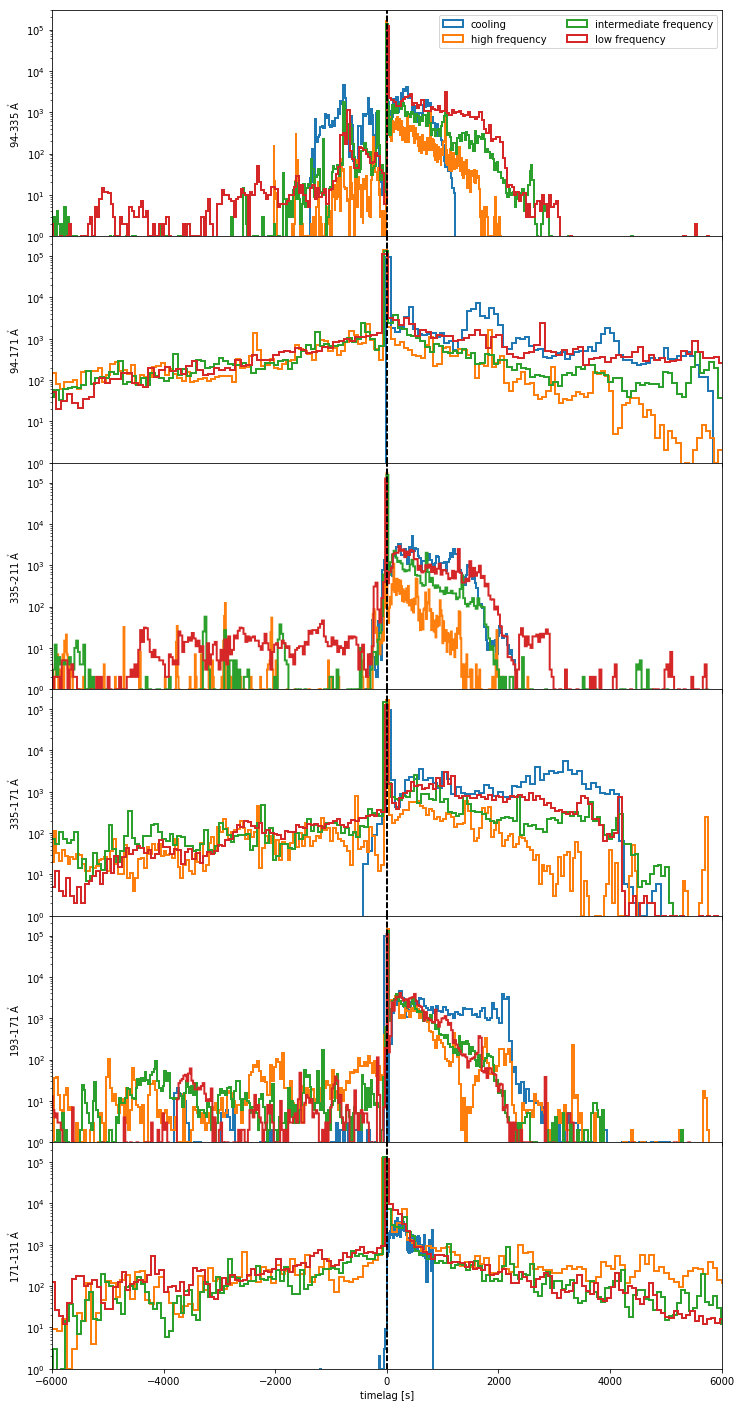

In [21]:
params = {'log':True,'bins':'scott','histtype':'step','lw':2,'normed':False,}
fig,axes = plt.subplots(len(channel_pairs),1,figsize=(12,25),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0)
tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    for j,heating in enumerate(['cooling','high_frequency','intermediate_frequency','low_frequency']):
        tmp = Map(tlm_format.format(heating,*p))
        ax.hist(tmp.data.flatten(),**params,label=' '.join(heating.split('_')),color=f'C{j}',ls='-')
        ax.axvline(x=0,ls='--',color='k')
        if i==0:
            ax.legend(loc='best',ncol=2)
        ax.set_ylabel(r'{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
axes[0].set_xlim(-6e3,6e3)
axes[0].set_ylim(1,3e5)
axes[-1].set_xlabel(r'timelag [s]')

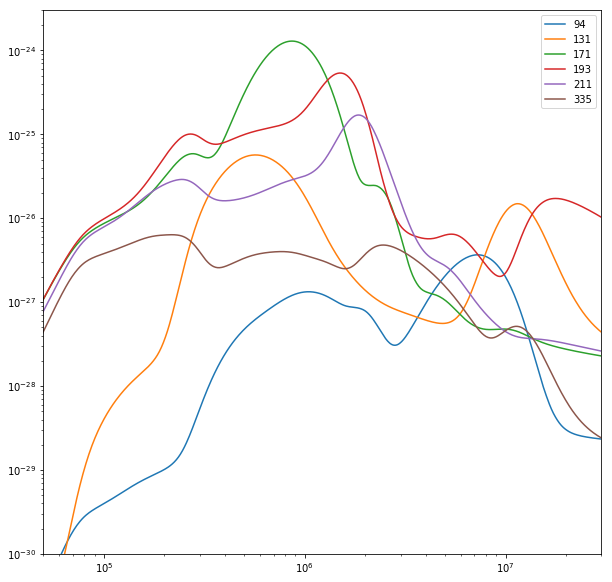

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
temperature_grid = np.logspace(4,9,1000)
for channel in aia_cooling.channels:
    resp = splev(temperature_grid, channel['temperature_response_spline'])
    ax.plot(temperature_grid,resp,label=channel['name'])
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1e-30,3e-24)
plt.xlim(5e4,3e7)
ax.legend()

## Computing Similarity to Observed Maps
One possible way to make a selection of the "best" heating model is to compute the observed timelags for all of these channels (using the same method as here) and then compute some sort of statistical distance between the distributions of timelags. A "pixel-by-pixel" comparison does not make much sense as this would likely be thrown off by the obvious issues with the field extrapolation and would not be a great test of the heating model itself.